In [6]:
###############################################
# 1) IMPORT LIBRARIES & SET PATHS
###############################################
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path


PREPROCESS_ROOT = "/kaggle/input/my-preprocessed-data/preprocessed/preprocessed"

CHECKPOINT_DIR = "/kaggle/working/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("Using dataset at:", PREPROCESS_ROOT)
print("Saving models to:", CHECKPOINT_DIR)


Using dataset at: /kaggle/input/my-preprocessed-data/preprocessed/preprocessed
Saving models to: /kaggle/working/checkpoints


In [7]:
###############################################
# 2) DATASET CLASS
###############################################
class PTDataset(Dataset):
    def __init__(self, imgs, gts):
        self.imgs = imgs
        self.gts = gts

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = torch.load(self.imgs[idx]).float()
        gt  = torch.load(self.gts[idx]).float()

        if img.ndim == 2: img = img.unsqueeze(0)
        if gt.ndim == 2:  gt = gt.unsqueeze(0)

        return img, gt


In [8]:
###############################################
# 3) LOAD TRAIN / VAL DATA  + VERIFY COUNTS
###############################################
from pathlib import Path

# Correct TrainA paths
train_img_dir = f"{PREPROCESS_ROOT}/TrainA/images"
train_gt_dir  = f"{PREPROCESS_ROOT}/TrainA/gt"

# List .pt files
train_imgs = sorted([str(p) for p in Path(train_img_dir).glob("*.pt")])
train_gts  = sorted([str(p) for p in Path(train_gt_dir).glob("*.pt")])

# Verify counts
print("Total image files in TrainA:", len(train_imgs))
print("Total GT files in TrainA   :", len(train_gts))

# Sanity check
if len(train_imgs) != len(train_gts):
    print("WARNING: Image/GT count mismatch!")

# 10% validation split
num = len(train_imgs)
val_num = num // 10
print("Validation size:", val_num)

train_imgs_split = train_imgs[:-val_num]
train_gts_split  = train_gts[:-val_num]
val_imgs_split   = train_imgs[-val_num:]
val_gts_split    = train_gts[-val_num:]

# Create datasets
train_ds = PTDataset(train_imgs_split, train_gts_split)
val_ds   = PTDataset(val_imgs_split, val_gts_split)

print("Training samples:", len(train_ds))
print("Validation samples:", len(val_ds))

# Read GT size for CSRNet wrapper
_, sample_gt = train_ds[0]
GT_H, GT_W = sample_gt.shape[-2], sample_gt.shape[-1]
print("GT shape detected:", GT_H, "x", GT_W)


Total image files in TrainA: 300
Total GT files in TrainA   : 300
Validation size: 30
Training samples: 270
Validation samples: 30
GT shape detected: 64 x 64


In [9]:
###############################################
# 4) DATALOADERS + CSRNET MODEL
###############################################
# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

# CSRNET MODEL 
class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])
        self.backend = nn.Sequential(
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(512,512,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(512,256,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(256,128,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(128,64,3,padding=2,dilation=2), nn.ReLU(),
            nn.Conv2d(64,1,1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

# Wrapper to match GT size
class CSRNetWrapper(nn.Module):
    def __init__(self, core, h, w):
        super().__init__()
        self.core = core
        self.h, self.w = h, w

    def forward(self, x):
        out = self.core(x)
        if out.shape[-2:] != (self.h, self.w):
            out = F.interpolate(out, size=(self.h, self.w), mode='bilinear', align_corners=False)
        return out

model = CSRNetWrapper(CSRNet(), GT_H, GT_W).cuda()
print("Model loaded.")


Train batches: 34
Val batches: 4
Model loaded.


In [10]:
###############################################
# 5) OPTIMIZER & LOSS
###############################################
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

NUM_EPOCHS = 300
best_val_loss = float("inf")

print("Training for", NUM_EPOCHS, "epochs...")


Training for 300 epochs...


In [11]:
###############################################
# 6) TRAINING LOOP (300 EPOCHS)
###############################################
for epoch in range(1, NUM_EPOCHS+1):

    # TRAIN
    model.train()
    train_loss = 0
    for imgs, gts in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
        imgs, gts = imgs.cuda(), gts.cuda()
        preds = model(imgs)
        loss = criterion(preds, gts)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)

    # VALIDATION
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, gts in tqdm(val_loader, desc=f"Epoch {epoch} Val"):
            imgs, gts = imgs.cuda(), gts.cuda()
            preds = model(imgs)
            val_loss += criterion(preds, gts).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch}: Train={train_loss:.6f}  Val={val_loss:.6f}")

    # Save every 50 epochs
    if epoch % 50 == 0:
        ckpt_path = f"{CHECKPOINT_DIR}/checkpoint_epoch{epoch}.pth"
        torch.save({"epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict()}, ckpt_path)
        print("Saved:", ckpt_path)

    # Save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_path = f"{CHECKPOINT_DIR}/best_model.pth"
        torch.save({"epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict()}, best_path)
        

# Save final model
print("BEST model saved:", best_path)
final_path = f"{CHECKPOINT_DIR}/final_epoch300.pth"
torch.save({"epoch": 300, "model_state": model.state_dict()}, final_path)
print("FINAL model saved:", final_path)


Epoch 1 Val: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


Epoch 1: Train=0.094415  Val=0.069533


Epoch 2 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 2: Train=0.057242  Val=0.051764


Epoch 3 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 3: Train=0.046700  Val=0.048932


Epoch 4 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 4: Train=0.042022  Val=0.045078


Epoch 5 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 5: Train=0.041267  Val=0.052663


Epoch 6 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 6: Train=0.040377  Val=0.047065


Epoch 7 Val: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Epoch 7: Train=0.034449  Val=0.046294


Epoch 8 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 8: Train=0.031690  Val=0.041937


Epoch 9 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 9: Train=0.030921  Val=0.038758


Epoch 10 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 10: Train=0.030290  Val=0.040972


Epoch 11 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 11: Train=0.030213  Val=0.039792


Epoch 12 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 12: Train=0.027317  Val=0.045666


Epoch 13 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 13: Train=0.027987  Val=0.040723


Epoch 14 Val: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 14: Train=0.025989  Val=0.041527


Epoch 15 Val: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 15: Train=0.024271  Val=0.041368


Epoch 16 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 16: Train=0.023639  Val=0.042981


Epoch 17 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 17: Train=0.023694  Val=0.043683


Epoch 18 Val: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 18: Train=0.024328  Val=0.044358


Epoch 19 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 19: Train=0.022441  Val=0.044056


Epoch 20 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 20: Train=0.021342  Val=0.045617


Epoch 21 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 21: Train=0.020917  Val=0.047784


Epoch 22 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 22: Train=0.021079  Val=0.048031


Epoch 23 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 23: Train=0.022680  Val=0.053526


Epoch 24 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 24: Train=0.022964  Val=0.042906


Epoch 25 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 25: Train=0.019642  Val=0.041548


Epoch 26 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 26: Train=0.019163  Val=0.043376


Epoch 27 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 27: Train=0.018810  Val=0.042689


Epoch 28 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 28: Train=0.019933  Val=0.038263


Epoch 29 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 29: Train=0.018919  Val=0.049032


Epoch 30 Val: 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 30: Train=0.019274  Val=0.046530


Epoch 31 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 31: Train=0.018723  Val=0.048431


Epoch 32 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 32: Train=0.017749  Val=0.049128


Epoch 33 Val: 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Epoch 33: Train=0.017271  Val=0.043481


Epoch 34 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 34: Train=0.017184  Val=0.045493


Epoch 35 Val: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Epoch 35: Train=0.016835  Val=0.046376


Epoch 36 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 36: Train=0.016605  Val=0.046960


Epoch 37 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 37: Train=0.016376  Val=0.045586


Epoch 38 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 38: Train=0.015962  Val=0.046279


Epoch 39 Val: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


Epoch 39: Train=0.016582  Val=0.044706


Epoch 40 Val: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Epoch 40: Train=0.018721  Val=0.050675


Epoch 41 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 41: Train=0.016628  Val=0.041263


Epoch 42 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 42: Train=0.015458  Val=0.046792


Epoch 43 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 43: Train=0.015588  Val=0.042103


Epoch 44 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 44: Train=0.016082  Val=0.045914


Epoch 45 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 45: Train=0.015590  Val=0.046551


Epoch 46 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 46: Train=0.016391  Val=0.042044


Epoch 47 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 47: Train=0.015098  Val=0.048281


Epoch 48 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 48: Train=0.015619  Val=0.041709


Epoch 49 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 49: Train=0.014436  Val=0.045308


Epoch 50 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 50: Train=0.014271  Val=0.041941
Saved: /kaggle/working/checkpoints/checkpoint_epoch50.pth


Epoch 51 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 51: Train=0.017317  Val=0.043444


Epoch 52 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 52: Train=0.015429  Val=0.055347


Epoch 53 Val: 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Epoch 53: Train=0.015730  Val=0.043005


Epoch 54 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 54: Train=0.014284  Val=0.044042


Epoch 55 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 55: Train=0.013758  Val=0.048030


Epoch 56 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 56: Train=0.013256  Val=0.046001


Epoch 57 Val: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 57: Train=0.012959  Val=0.048946


Epoch 58 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 58: Train=0.012862  Val=0.046397


Epoch 59 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 59: Train=0.012629  Val=0.046869


Epoch 60 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 60: Train=0.012658  Val=0.047707


Epoch 61 Val: 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Epoch 61: Train=0.013821  Val=0.048551


Epoch 62 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 62: Train=0.017366  Val=0.049449


Epoch 63 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 63: Train=0.017458  Val=0.048899


Epoch 64 Val: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 64: Train=0.013939  Val=0.048516


Epoch 65 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 65: Train=0.013027  Val=0.050348


Epoch 66 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 66: Train=0.012863  Val=0.044831


Epoch 67 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 67: Train=0.012418  Val=0.044279


Epoch 68 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 68: Train=0.012119  Val=0.046285


Epoch 69 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 69: Train=0.011829  Val=0.046011


Epoch 70 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 70: Train=0.011911  Val=0.045955


Epoch 71 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 71: Train=0.011930  Val=0.044088


Epoch 72 Val: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 72: Train=0.011613  Val=0.046160


Epoch 73 Val: 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch 73: Train=0.011271  Val=0.044518


Epoch 74 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 74: Train=0.011097  Val=0.046280


Epoch 75 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 75: Train=0.010976  Val=0.044311


Epoch 76 Val: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 76: Train=0.011288  Val=0.051238


Epoch 77 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 77: Train=0.011408  Val=0.043142


Epoch 78 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 78: Train=0.011347  Val=0.046676


Epoch 79 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 79: Train=0.011383  Val=0.042719


Epoch 80 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 80: Train=0.011740  Val=0.050047


Epoch 81 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 81: Train=0.010823  Val=0.047198


Epoch 82 Val: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 82: Train=0.010617  Val=0.050633


Epoch 83 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 83: Train=0.010523  Val=0.045910


Epoch 84 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 84: Train=0.010169  Val=0.046669


Epoch 85 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 85: Train=0.010016  Val=0.046521


Epoch 86 Val: 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Epoch 86: Train=0.011272  Val=0.047681


Epoch 87 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 87: Train=0.010469  Val=0.044736


Epoch 88 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 88: Train=0.012235  Val=0.052800


Epoch 89 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 89: Train=0.012139  Val=0.055171


Epoch 90 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 90: Train=0.011780  Val=0.045577


Epoch 91 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 91: Train=0.009809  Val=0.046574


Epoch 92 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 92: Train=0.009336  Val=0.045312


Epoch 93 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 93: Train=0.009107  Val=0.045976


Epoch 94 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 94: Train=0.009057  Val=0.045694


Epoch 95 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 95: Train=0.008944  Val=0.047237


Epoch 96 Val: 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 96: Train=0.008923  Val=0.046207


Epoch 97 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 97: Train=0.008880  Val=0.046972


Epoch 98 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 98: Train=0.008997  Val=0.049308


Epoch 99 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 99: Train=0.009445  Val=0.047796


Epoch 100 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 100: Train=0.008765  Val=0.044588
Saved: /kaggle/working/checkpoints/checkpoint_epoch100.pth


Epoch 101 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 101: Train=0.008938  Val=0.045904


Epoch 102 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 102: Train=0.008872  Val=0.047912


Epoch 103 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 103: Train=0.009087  Val=0.048078


Epoch 104 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 104: Train=0.008713  Val=0.045329


Epoch 105 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 105: Train=0.009077  Val=0.043636


Epoch 106 Val: 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 106: Train=0.009357  Val=0.044160


Epoch 107 Val: 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Epoch 107: Train=0.009414  Val=0.048850


Epoch 108 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 108: Train=0.008963  Val=0.047116


Epoch 109 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 109: Train=0.008478  Val=0.044492


Epoch 110 Val: 100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


Epoch 110: Train=0.007996  Val=0.043976


Epoch 111 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 111: Train=0.007779  Val=0.047244


Epoch 112 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 112: Train=0.007583  Val=0.044664


Epoch 113 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 113: Train=0.007469  Val=0.047657


Epoch 114 Val: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Epoch 114: Train=0.007356  Val=0.047238


Epoch 115 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 115: Train=0.007284  Val=0.046362


Epoch 116 Val: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch 116: Train=0.007134  Val=0.047247


Epoch 117 Val: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


Epoch 117: Train=0.007030  Val=0.046660


Epoch 118 Val: 100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


Epoch 118: Train=0.006898  Val=0.046999


Epoch 119 Val: 100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


Epoch 119: Train=0.007288  Val=0.046139


Epoch 120 Val: 100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


Epoch 120: Train=0.007587  Val=0.048927


Epoch 121 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 121: Train=0.007671  Val=0.049500


Epoch 122 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 122: Train=0.008192  Val=0.047523


Epoch 123 Val: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch 123: Train=0.007383  Val=0.046906


Epoch 124 Val: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


Epoch 124: Train=0.007253  Val=0.052509


Epoch 125 Val: 100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


Epoch 125: Train=0.008764  Val=0.048442


Epoch 126 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 126: Train=0.008035  Val=0.048943


Epoch 127 Val: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 127: Train=0.008039  Val=0.047084


Epoch 128 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 128: Train=0.008809  Val=0.046938


Epoch 129 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 129: Train=0.008617  Val=0.043897


Epoch 130 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 130: Train=0.007802  Val=0.050147


Epoch 131 Val: 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 131: Train=0.007050  Val=0.044649


Epoch 132 Val: 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Epoch 132: Train=0.006459  Val=0.049006


Epoch 133 Val: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Epoch 133: Train=0.006115  Val=0.047309


Epoch 134 Val: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 134: Train=0.006372  Val=0.046227


Epoch 135 Val: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch 135: Train=0.006804  Val=0.048160


Epoch 136 Val: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 136: Train=0.006578  Val=0.043089


Epoch 137 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 137: Train=0.006708  Val=0.045362


Epoch 138 Val: 100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


Epoch 138: Train=0.006688  Val=0.049425


Epoch 139 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 139: Train=0.006765  Val=0.042825


Epoch 140 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 140: Train=0.006310  Val=0.047943


Epoch 141 Val: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


Epoch 141: Train=0.005738  Val=0.045100


Epoch 142 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 142: Train=0.005666  Val=0.046811


Epoch 143 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 143: Train=0.005562  Val=0.047946


Epoch 144 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 144: Train=0.005703  Val=0.048479


Epoch 145 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 145: Train=0.005560  Val=0.047107


Epoch 146 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 146: Train=0.005468  Val=0.045818


Epoch 147 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 147: Train=0.005312  Val=0.046355


Epoch 148 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 148: Train=0.005635  Val=0.048670


Epoch 149 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 149: Train=0.006243  Val=0.044206


Epoch 150 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 150: Train=0.006321  Val=0.043454
Saved: /kaggle/working/checkpoints/checkpoint_epoch150.pth


Epoch 151 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 151: Train=0.006189  Val=0.049519


Epoch 152 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 152: Train=0.005373  Val=0.048325


Epoch 153 Val: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 153: Train=0.005325  Val=0.044817


Epoch 154 Val: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 154: Train=0.005100  Val=0.050536


Epoch 155 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 155: Train=0.005272  Val=0.049025


Epoch 156 Val: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 156: Train=0.005043  Val=0.045798


Epoch 157 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 157: Train=0.005646  Val=0.048600


Epoch 158 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 158: Train=0.005593  Val=0.049180


Epoch 159 Val: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 159: Train=0.005426  Val=0.047879


Epoch 160 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 160: Train=0.006592  Val=0.053160


Epoch 161 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 161: Train=0.007270  Val=0.041691


Epoch 162 Val: 100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


Epoch 162: Train=0.011774  Val=0.050064


Epoch 163 Val: 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


Epoch 163: Train=0.007443  Val=0.045988


Epoch 164 Val: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


Epoch 164: Train=0.006079  Val=0.046658


Epoch 165 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 165: Train=0.005063  Val=0.049017


Epoch 166 Val: 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Epoch 166: Train=0.005015  Val=0.047664


Epoch 167 Val: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 167: Train=0.004582  Val=0.047513


Epoch 168 Val: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 168: Train=0.004423  Val=0.048813


Epoch 169 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 169: Train=0.004316  Val=0.047164


Epoch 170 Val: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 170: Train=0.004148  Val=0.048507


Epoch 171 Val: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 171: Train=0.004135  Val=0.047863


Epoch 172 Val: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 172: Train=0.004129  Val=0.048470


Epoch 173 Val: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Epoch 173: Train=0.003996  Val=0.048882


Epoch 174 Val: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch 174: Train=0.003973  Val=0.047189


Epoch 175 Val: 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch 175: Train=0.003976  Val=0.049732


Epoch 176 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 176: Train=0.003846  Val=0.049056


Epoch 177 Val: 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Epoch 177: Train=0.003763  Val=0.048023


Epoch 178 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 178: Train=0.003706  Val=0.047383


Epoch 179 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 179: Train=0.003687  Val=0.048498


Epoch 180 Val: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch 180: Train=0.003627  Val=0.048112


Epoch 181 Val: 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch 181: Train=0.003574  Val=0.048666


Epoch 182 Val: 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


Epoch 182: Train=0.003545  Val=0.048431


Epoch 183 Val: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 183: Train=0.003625  Val=0.046963


Epoch 184 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 184: Train=0.003611  Val=0.049692


Epoch 185 Val: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 185: Train=0.003503  Val=0.048127


Epoch 186 Val: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 186: Train=0.003463  Val=0.049240


Epoch 187 Val: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 187: Train=0.003923  Val=0.051034


Epoch 188 Val: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 188: Train=0.004564  Val=0.050794


Epoch 189 Val: 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 189: Train=0.004146  Val=0.047845


Epoch 190 Val: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 190: Train=0.003715  Val=0.049870


Epoch 191 Val: 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 191: Train=0.003425  Val=0.048295


Epoch 192 Val: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 192: Train=0.003603  Val=0.049947


Epoch 193 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 193: Train=0.003768  Val=0.049647


Epoch 194 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 194: Train=0.004534  Val=0.049997


Epoch 195 Val: 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch 195: Train=0.004202  Val=0.048386


Epoch 196 Val: 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


Epoch 196: Train=0.003598  Val=0.049138


Epoch 197 Val: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 197: Train=0.003595  Val=0.045816


Epoch 198 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 198: Train=0.003676  Val=0.050796


Epoch 199 Val: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch 199: Train=0.003644  Val=0.046709


Epoch 200 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 200: Train=0.004742  Val=0.045849
Saved: /kaggle/working/checkpoints/checkpoint_epoch200.pth


Epoch 201 Val: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch 201: Train=0.005453  Val=0.050899


Epoch 202 Val: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 202: Train=0.004802  Val=0.046546


Epoch 203 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 203: Train=0.005102  Val=0.052670


Epoch 204 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 204: Train=0.003840  Val=0.046866


Epoch 205 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 205: Train=0.003528  Val=0.049958


Epoch 206 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 206: Train=0.004091  Val=0.047996


Epoch 207 Val: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch 207: Train=0.003357  Val=0.047122


Epoch 208 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 208: Train=0.003367  Val=0.048213


Epoch 209 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 209: Train=0.003124  Val=0.047115


Epoch 210 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 210: Train=0.003250  Val=0.051392


Epoch 211 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 211: Train=0.003167  Val=0.051360


Epoch 212 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 212: Train=0.003585  Val=0.050423


Epoch 213 Val: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 213: Train=0.003396  Val=0.047445


Epoch 214 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 214: Train=0.002731  Val=0.050091


Epoch 215 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 215: Train=0.002890  Val=0.047770


Epoch 216 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 216: Train=0.003059  Val=0.048716


Epoch 217 Val: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch 217: Train=0.002670  Val=0.048601


Epoch 218 Val: 100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


Epoch 218: Train=0.002517  Val=0.048795


Epoch 219 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 219: Train=0.002418  Val=0.048326


Epoch 220 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 220: Train=0.002325  Val=0.049425


Epoch 221 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 221: Train=0.002273  Val=0.049394


Epoch 222 Val: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch 222: Train=0.002242  Val=0.049466


Epoch 223 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 223: Train=0.002235  Val=0.049977


Epoch 224 Val: 100%|██████████| 4/4 [00:00<00:00,  5.60it/s]


Epoch 224: Train=0.002349  Val=0.048719


Epoch 225 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 225: Train=0.002246  Val=0.048469


Epoch 226 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 226: Train=0.002260  Val=0.049354


Epoch 227 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 227: Train=0.002214  Val=0.048789


Epoch 228 Val: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Epoch 228: Train=0.002169  Val=0.049441


Epoch 229 Val: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Epoch 229: Train=0.002117  Val=0.049064


Epoch 230 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 230: Train=0.002165  Val=0.049253


Epoch 231 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 231: Train=0.002043  Val=0.048613


Epoch 232 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 232: Train=0.002096  Val=0.049336


Epoch 233 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 233: Train=0.002104  Val=0.049215


Epoch 234 Val: 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 234: Train=0.002288  Val=0.050698


Epoch 235 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 235: Train=0.002612  Val=0.052393


Epoch 236 Val: 100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


Epoch 236: Train=0.002683  Val=0.053775


Epoch 237 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 237: Train=0.002760  Val=0.048333


Epoch 238 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 238: Train=0.003344  Val=0.048099


Epoch 239 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 239: Train=0.002277  Val=0.049261


Epoch 240 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 240: Train=0.001984  Val=0.049257


Epoch 241 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 241: Train=0.001896  Val=0.049907


Epoch 242 Val: 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 242: Train=0.001928  Val=0.050012


Epoch 243 Val: 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 243: Train=0.001842  Val=0.049621


Epoch 244 Val: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 244: Train=0.001707  Val=0.049582


Epoch 245 Val: 100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 245: Train=0.001656  Val=0.049543


Epoch 246 Val: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 246: Train=0.001619  Val=0.050235


Epoch 247 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 247: Train=0.001648  Val=0.050005


Epoch 248 Val: 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 248: Train=0.001689  Val=0.049348


Epoch 249 Val: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Epoch 249: Train=0.001697  Val=0.048308


Epoch 250 Val: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 250: Train=0.001621  Val=0.049986
Saved: /kaggle/working/checkpoints/checkpoint_epoch250.pth


Epoch 251 Val: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 251: Train=0.001593  Val=0.049872


Epoch 252 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 252: Train=0.001744  Val=0.049636


Epoch 253 Val: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 253: Train=0.001631  Val=0.050136


Epoch 254 Val: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 254: Train=0.001642  Val=0.049439


Epoch 255 Val: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 255: Train=0.001616  Val=0.049927


Epoch 256 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 256: Train=0.001579  Val=0.050360


Epoch 257 Val: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 257: Train=0.001487  Val=0.049949


Epoch 258 Val: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 258: Train=0.001596  Val=0.051620


Epoch 259 Val: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 259: Train=0.002266  Val=0.048968


Epoch 260 Val: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 260: Train=0.002319  Val=0.049208


Epoch 261 Val: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 261: Train=0.002357  Val=0.053214


Epoch 262 Val: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 262: Train=0.002149  Val=0.048031


Epoch 263 Val: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 263: Train=0.003099  Val=0.053570


Epoch 264 Val: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 264: Train=0.002756  Val=0.047209


Epoch 265 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 265: Train=0.005172  Val=0.050866


Epoch 266 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 266: Train=0.010339  Val=0.054791


Epoch 267 Val: 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch 267: Train=0.007133  Val=0.059176


Epoch 268 Val: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 268: Train=0.004299  Val=0.048526


Epoch 269 Val: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 269: Train=0.002295  Val=0.050133


Epoch 270 Val: 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 270: Train=0.002381  Val=0.054324


Epoch 271 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 271: Train=0.001780  Val=0.050139


Epoch 272 Val: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 272: Train=0.001498  Val=0.050512


Epoch 273 Val: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch 273: Train=0.001315  Val=0.050731


Epoch 274 Val: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 274: Train=0.001240  Val=0.051446


Epoch 275 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 275: Train=0.001208  Val=0.050216


Epoch 276 Val: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 276: Train=0.001175  Val=0.050270


Epoch 277 Val: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 277: Train=0.001171  Val=0.050876


Epoch 278 Val: 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


Epoch 278: Train=0.001217  Val=0.051050


Epoch 279 Val: 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 279: Train=0.001181  Val=0.050979


Epoch 280 Val: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 280: Train=0.001122  Val=0.050351


Epoch 281 Val: 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 281: Train=0.001098  Val=0.050741


Epoch 282 Val: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 282: Train=0.001065  Val=0.050062


Epoch 283 Val: 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 283: Train=0.001055  Val=0.050394


Epoch 284 Val: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 284: Train=0.001034  Val=0.050220


Epoch 285 Val: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 285: Train=0.001020  Val=0.050498


Epoch 286 Val: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 286: Train=0.001008  Val=0.050452


Epoch 287 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 287: Train=0.000996  Val=0.050513


Epoch 288 Val: 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 288: Train=0.000981  Val=0.050608


Epoch 289 Val: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch 289: Train=0.000972  Val=0.050469


Epoch 290 Val: 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch 290: Train=0.001001  Val=0.050215


Epoch 291 Val: 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch 291: Train=0.000978  Val=0.050876


Epoch 292 Val: 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch 292: Train=0.000965  Val=0.050958


Epoch 293 Val: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 293: Train=0.000985  Val=0.051172


Epoch 294 Val: 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 294: Train=0.000984  Val=0.050181


Epoch 295 Val: 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch 295: Train=0.001026  Val=0.051087


Epoch 296 Val: 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Epoch 296: Train=0.001004  Val=0.051413


Epoch 297 Val: 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]


Epoch 297: Train=0.000927  Val=0.050194


Epoch 298 Val: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 298: Train=0.000909  Val=0.050371


Epoch 299 Val: 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 299: Train=0.000896  Val=0.051277


Epoch 300 Val: 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 300: Train=0.000960  Val=0.050199
Saved: /kaggle/working/checkpoints/checkpoint_epoch300.pth
BEST model saved: /kaggle/working/checkpoints/best_model.pth
FINAL model saved: /kaggle/working/checkpoints/final_epoch300.pth


In [13]:
###############################################
# 7) TESTING
###############################################
test_img_dir = "/kaggle/input/my-preprocessed-data/preprocessed/preprocessed/TestA/images"
test_gt_dir  = "/kaggle/input/my-preprocessed-data/preprocessed/preprocessed/TestA/gt"

test_imgs = sorted([str(p) for p in Path(test_img_dir).glob("*.pt")])
test_gts  = sorted([str(p) for p in Path(test_gt_dir).glob("*.pt")])

test_ds = PTDataset(test_imgs, test_gts)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

abs_errs = []
sq_errs  = []
acc_list = []
pix_mae_list = []
pix_mse_list = []

model.eval()
with torch.no_grad():
    for imgs, gts in tqdm(test_loader, desc="Testing"):
        imgs, gts = imgs.cuda(), gts.cuda()
        preds = model(imgs)

        # pixel errors
        mae = torch.abs(preds-gts).mean(dim=[1,2,3]).cpu().numpy()
        mse = ((preds-gts)**2).mean(dim=[1,2,3]).cpu().numpy()
        pix_mae_list.extend(mae)
        pix_mse_list.extend(mse)

        # count errors
        pc = preds.sum(dim=[1,2,3]).cpu().numpy()
        gc = gts.sum(dim=[1,2,3]).cpu().numpy()

        for p, g in zip(pc, gc):
            abs_errs.append(abs(p-g))
            sq_errs.append((p-g)**2)

            if g > 0:
                acc = max(0, 1 - abs(p-g)/g)
            else:
                acc = 1 if p < 1e-6 else 0

            acc_list.append(acc)

print("\n=== TEST RESULTS ===")
print("Pixel MAE:", float(np.mean(pix_mae_list)))
print("Pixel RMSE:", float(np.sqrt(np.mean(pix_mse_list))))
print("Count MAE:", float(np.mean(abs_errs)))
print("Count RMSE:", float(np.sqrt(np.mean(sq_errs))))
print("Counting Accuracy:", float(np.mean(acc_list))*100, "%")


Testing: 100%|██████████| 23/23 [00:11<00:00,  2.06it/s]


=== TEST RESULTS ===
Pixel MAE: 0.07783535867929459
Pixel RMSE: 0.1735086441040039
Count MAE: 78.8944091796875
Count RMSE: 122.78108285295504
Counting Accuracy: 80.47315208546854 %


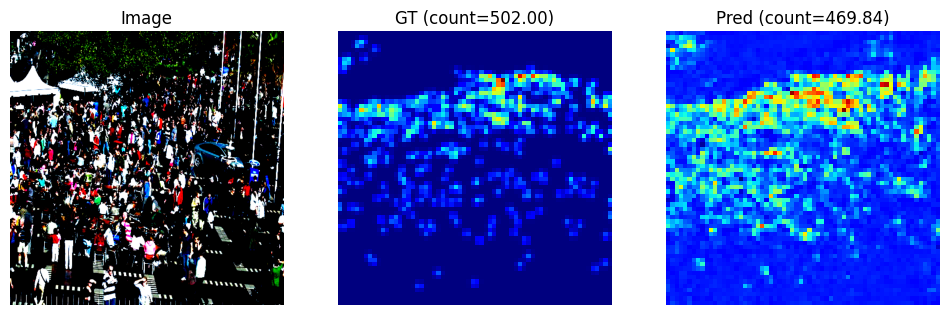

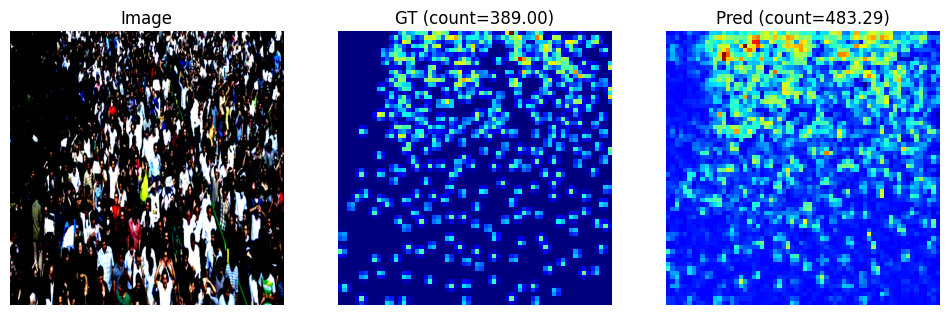

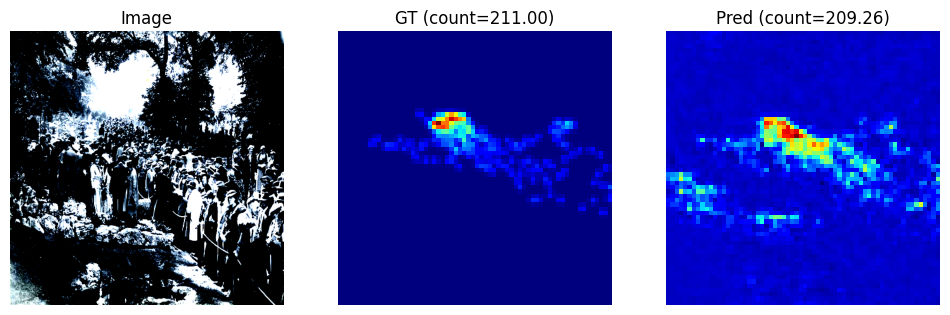

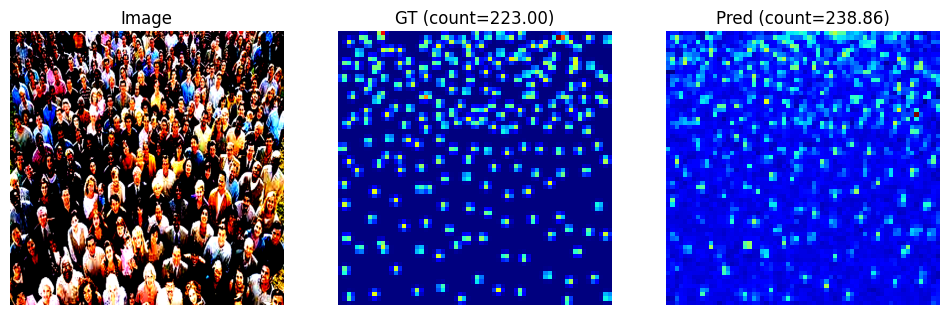

In [14]:
###############################################
# 8) VISUALIZE 4 SAMPLES
###############################################

def show_map(img, gt, pred):
    # Convert image tensor to numpy
    img = img.permute(1,2,0).cpu().numpy()
    img = np.clip(img, 0, 1)

    # Convert GT & prediction to numpy
    gt_map = gt.squeeze().cpu().numpy()
    pr_map = pred.squeeze().cpu().numpy()

    # Plot
    plt.figure(figsize=(12,4))

    # Original image
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Image")

    # GT density
    plt.subplot(1,3,2)
    plt.imshow(gt_map, cmap="jet")
    plt.axis("off")
    plt.title(f"GT (count={gt_map.sum():.2f})")

    # Predicted density
    plt.subplot(1,3,3)
    plt.imshow(pr_map, cmap="jet")
    plt.axis("off")
    plt.title(f"Pred (count={pr_map.sum():.2f})")

    plt.show()


# ---- RUN VISUALIZATION FOR 4 SAMPLES ----
for i in range(4):
    img, gt = test_ds[i]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).cuda())[0].cpu()
    show_map(img, gt, pred)


In [15]:
import os
print(os.getcwd())
import os
print(os.listdir('/kaggle/working'))


/kaggle/working
['checkpoints', '.ipynb_checkpoints', '.virtual_documents']
